### Test the impact of compressing images on the memory usage of KBMOD
author: ajc@astro.washington.edu

date: 8/22/2022

Simulate a set of images with noise and add a low signal to noise source (images are floats)

Measure the flux and SNR (assumes rectangular sources) for the source

Coadd a set of images to show we can recover a higher SNR source

Compress the images by assuming we can truncate the images to unit8 where we truncate the data +/- 128 counts above and below the sky and rescale so all pixel values are positive

Recalculate the flux and SNR in the compressed and coadded images

In [46]:
import numpy as np
import os
import subprocess
from matplotlib import pyplot as plt

class Image (object):
    def __init__(self, nx, ny):
        '''Initialize image with zero background'''
        self.nx = nx
        self.ny = ny
        self.data = np.zeros((nx,ny))

    def addNoise(self, mean, sigma):
        '''Add noise'''
        self.data += np.random.normal(mean, sigma, size=(self.nx, self.ny)) 

    def addSource(self, x, y, flux, size=2):
        self.data[x-size:x+size, y-size:y+size] += flux

    def calculateRMS(self) -> float:
        return self.data.std()

    def findBackground(self, buffer) -> (float, float):
        return self.data[0:buffer,:].mean(), self.data[0:buffer,:].std()

    def measureSNR(self, x, y, size=2) -> (float, float):
        background, noise = self.findBackground(10)
        #print (background, noise)
        flux = self.data[x-size:x+size, y-size:y+size].sum() - background*4*size*size
        snr = flux / (np.sqrt(4*size*size)*noise)
        return flux, snr

    def checkSize(self, filename='_data.npy') -> float:
        np.save(filename, self.data)
        return (os.path.getsize(filename))
 
    def checkCompressedSize(self, filename='_data.npy') -> float:
        np.save(filename, self.data)
        subprocess.call('xz -f -9 {}'.format(filename), shell=True)
        return os.path.getsize('{}.xz'.format(filename))

    

def coaddImage(imageList):
    coadd = Image(imageList[0].nx, imageList[0].ny)
    for im in imageList:
        coadd.data = coadd.data + im.data
    coadd.data /= len(imageList)
    return coadd

def truncateImage(image, min, max):
    clipped = Image(image.nx, image.ny)
    clipped.data = image.data.clip(min, max)
    clipped.data -= min
    clipped.data = np.floor_divide(clipped.data, (max - min + 1) / 256, casting='unsafe').astype(np.uint8)
    return clipped


In [47]:

#set up image and noise
nx = 100
ny = 100
mean = 0
std = 5

#add source to image
x=50
y=50
size=2
area= 4*size**2
input_snr = 1.
pixel_flux = input_snr*std*np.sqrt(area)/(area)

image0 = Image(nx, ny)
image0.addNoise(mean, std)
image0.addSource(x, y, pixel_flux, size=size)

# measure flux and SNR for the source
flux, snr = image0.measureSNR(x, y, size=size)
print ("Single Image Input Flux: {}, Measured Flux: {} Measured SNR: {}".format(pixel_flux*area, flux, snr))


# create a set of images
nImage = 100
images = []
for i in np.arange(nImage):
    im = Image(nx, ny)
    im.addNoise(mean, std)
    im.addSource(x, y, pixel_flux, size=size)
    images.append(im)

#coadd images (coadd is divided by the number of images to preserve the source flux)
coadd = coaddImage(images)
flux, snr = coadd.measureSNR(x, y, size=size)
print ("Coadd Image Input Flux: {}, Measured Flux: {} Measured SNR: {}".format(pixel_flux*area, flux, snr))


# truncate an image counts (place a ceiling for the count values which essentially masks high pixel counts)
# use the same images as generated above
min = -128.
max = 128.
norm = (max - min) / 256 # assumes uint8
clippedImage = truncateImage(image0, min, max)
flux, snr = clippedImage.measureSNR(x, y, size=size)
print ("Clipped Image Input Flux: {}, Measured Clipped Image Flux: {} Measured SNR: {}".format(pixel_flux*area, flux*norm, snr))


clipImages = []
for im in images:
    clipImages.append(truncateImage(im, min, max))

coaddClipped = coaddImage(clipImages)
flux, snr = coaddClipped.measureSNR(x, y, size=size)
print ("Clipped Coadd Image Input Flux: {}, Measured Coadd Clipped Image Flux: {} Measured Coadd SNR: {}".format(pixel_flux*area, flux*norm, snr))

# compare sizes of the image
print ("Image Size {}, Compressed Image Size {}".format(image0.checkSize(), image0.checkCompressedSize()))
print ("Clipped Image Size {}, Clipped Compressed Image Size {}".format(clippedImage.checkSize(), clippedImage.checkCompressedSize()))



Single Image Input Flux: 20.0, Measured Flux: 39.47740795166469 Measured SNR: 2.0340354397553404
Coadd Image Input Flux: 20.0, Measured Flux: 19.602314734443254 Measured SNR: 9.933597904506735
Clipped Image Input Flux: 20.0, Measured Clipped Image Flux: 40.05600000000004 Measured SNR: 2.0683938576007814
Clipped Coadd Image Input Flux: 20.0, Measured Coadd Clipped Image Flux: 19.21383999999989 Measured Coadd SNR: 9.7976460008894
Image Size 80128, Compressed Image Size 75860
Clipped Image Size 10128, Clipped Compressed Image Size 5852


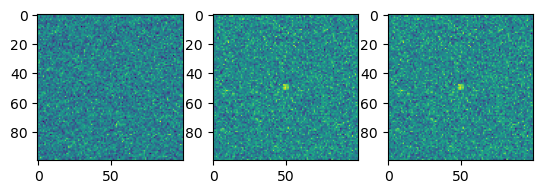

In [48]:

fig, ax = plt.subplots(1,3)
ax[0].imshow(image0.data)
ax[1].imshow(coadd.data)
ax[2].imshow(coaddClipped.data)
plt.show()